## Requirements

In [1]:
!pip install PySastrawi --quiet

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import random
import pickle
from google.colab import files

from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

## Load Data

In [3]:
FILE_ID = '1-AqUG58cEWYqrzxZ5_2gHF9Off8Nzpli'
URL = f'https://drive.google.com/uc?id={FILE_ID}'

In [4]:
def load_data(url=URL):
  df = pd.read_csv(url)
  df = df.dropna()

  return df

In [5]:
df = load_data()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364821 entries, 0 to 364820
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   text    364821 non-null  object 
 1   label   364821 non-null  float64
dtypes: float64(1), object(1)
memory usage: 5.6+ MB


In [6]:
df

,text,label
0,"aku merasa sedikit kotor, sedikit tercemar jik...",0.0
1,aku merasa gelisah sepanjang waktu seperti ham...,3.0
2,Saya ingat merasa bahwa saya tidak tahan denga...,3.0
3,"Saya merasa kewalahan, stres, dan sejujurnya s...",4.0
4,saya terkadang merasa seperti saya kehilangan ...,0.0
...,...,...
364816,"aku suka urutannya, itu membuatku merasa tenang",1.0
364817,Saya merasa itu tidak begitu populer di belaha...,1.0
364818,"Aku merasakan lidahnya menari di lidahku, aku ...",1.0
364819,"Saya merasa lega, saya merasa bersyukur dan se...",1.0


## Preprocessing

### 2. Clean Data and Remove Stopword

In [7]:
def clean_text(text):
    factory = StopWordRemoverFactory()
    stopword = factory.create_stop_word_remover()
    text = re.sub(r'[^\w\s]', ' ', text)                                      # Remove punctuation
    text = re.sub(r'#\w+', '', text)                                          # Remove hashtags
    text = re.sub(r'@\w+', '', text)                                          # Remove mentions
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)   # Remove URLs
    text = re.sub(r'\s+', ' ', text).strip()                                  # Remove excessive whitespace
    text = text.lower()                                                       # Case folding
    text = stopword.remove(text)                                              # Remove stopwords
    return text

In [8]:
df['clean_text'] = df['text'].apply(clean_text)
df = df[df['clean_text'] != '']

In [9]:
df

,text,label,clean_text
0,"aku merasa sedikit kotor, sedikit tercemar jik...",0.0,kotor tercemar mengirim enam belas tweet waktu...
1,aku merasa gelisah sepanjang waktu seperti ham...,3.0,gelisah waktu hamster mencari roda
2,Saya ingat merasa bahwa saya tidak tahan denga...,3.0,tahan karakter karakter seinfeld alasan repot ...
3,"Saya merasa kewalahan, stres, dan sejujurnya s...",4.0,kewalahan stres sejujurnya kehilangan akal sehat
4,saya terkadang merasa seperti saya kehilangan ...,0.0,terkadang kehilangan pengalaman melahirkan nor...
...,...,...,...
364816,"aku suka urutannya, itu membuatku merasa tenang",1.0,suka urutannya membuatku tenang
364817,Saya merasa itu tidak begitu populer di belaha...,1.0,populer belahan dunia
364818,"Aku merasakan lidahnya menari di lidahku, aku ...",1.0,merasakan lidahnya menari lidahku menarik cium...
364819,"Saya merasa lega, saya merasa bersyukur dan se...",1.0,lega bersyukur sejujurnya kewalahan selasa malam


### 2. Tokenization

In [10]:
def tokenize_text(text):
    return re.findall(r'\b\w+\b', text)

In [11]:
df['tokenized'] = df['clean_text'].apply(tokenize_text)

<ipython-input-11-0961081ef437>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tokenized'] = df['clean_text'].apply(tokenize_text)


In [12]:
df

,text,label,clean_text,tokenized
0,"aku merasa sedikit kotor, sedikit tercemar jik...",0.0,kotor tercemar mengirim enam belas tweet waktu...,"[kotor, tercemar, mengirim, enam, belas, tweet..."
1,aku merasa gelisah sepanjang waktu seperti ham...,3.0,gelisah waktu hamster mencari roda,"[gelisah, waktu, hamster, mencari, roda]"
2,Saya ingat merasa bahwa saya tidak tahan denga...,3.0,tahan karakter karakter seinfeld alasan repot ...,"[tahan, karakter, karakter, seinfeld, alasan, ..."
3,"Saya merasa kewalahan, stres, dan sejujurnya s...",4.0,kewalahan stres sejujurnya kehilangan akal sehat,"[kewalahan, stres, sejujurnya, kehilangan, aka..."
4,saya terkadang merasa seperti saya kehilangan ...,0.0,terkadang kehilangan pengalaman melahirkan nor...,"[terkadang, kehilangan, pengalaman, melahirkan..."
...,...,...,...,...
364816,"aku suka urutannya, itu membuatku merasa tenang",1.0,suka urutannya membuatku tenang,"[suka, urutannya, membuatku, tenang]"
364817,Saya merasa itu tidak begitu populer di belaha...,1.0,populer belahan dunia,"[populer, belahan, dunia]"
364818,"Aku merasakan lidahnya menari di lidahku, aku ...",1.0,merasakan lidahnya menari lidahku menarik cium...,"[merasakan, lidahnya, menari, lidahku, menarik..."
364819,"Saya merasa lega, saya merasa bersyukur dan se...",1.0,lega bersyukur sejujurnya kewalahan selasa malam,"[lega, bersyukur, sejujurnya, kewalahan, selas..."


### 4. Indexing

In [13]:
vocabulary = set()
for tokens in df['tokenized']:
    vocabulary.update(tokens)

word_to_index = {token: index + 1 for index, token in enumerate(vocabulary)}

In [14]:
def tokens_to_indices(tokens):
    return [word_to_index.get(token, 0) for token in tokens]

In [15]:
df['indexed'] = df['tokenized'].apply(tokens_to_indices)

<ipython-input-15-5abf8c10f0ee>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['indexed'] = df['tokenized'].apply(tokens_to_indices)


In [16]:
df

,text,label,clean_text,tokenized,indexed
0,"aku merasa sedikit kotor, sedikit tercemar jik...",0.0,kotor tercemar mengirim enam belas tweet waktu...,"[kotor, tercemar, mengirim, enam, belas, tweet...","[66049, 48025, 885, 37417, 748, 39016, 14998, ..."
1,aku merasa gelisah sepanjang waktu seperti ham...,3.0,gelisah waktu hamster mencari roda,"[gelisah, waktu, hamster, mencari, roda]","[71435, 14998, 41387, 23049, 72407]"
2,Saya ingat merasa bahwa saya tidak tahan denga...,3.0,tahan karakter karakter seinfeld alasan repot ...,"[tahan, karakter, karakter, seinfeld, alasan, ...","[43709, 5108, 5108, 57751, 20211, 44215, 44215..."
3,"Saya merasa kewalahan, stres, dan sejujurnya s...",4.0,kewalahan stres sejujurnya kehilangan akal sehat,"[kewalahan, stres, sejujurnya, kehilangan, aka...","[15590, 16377, 17363, 24976, 24678, 64399]"
4,saya terkadang merasa seperti saya kehilangan ...,0.0,terkadang kehilangan pengalaman melahirkan nor...,"[terkadang, kehilangan, pengalaman, melahirkan...","[36786, 24976, 24192, 30891, 1085, 2087]"
...,...,...,...,...,...
364816,"aku suka urutannya, itu membuatku merasa tenang",1.0,suka urutannya membuatku tenang,"[suka, urutannya, membuatku, tenang]","[19775, 11277, 64770, 55354]"
364817,Saya merasa itu tidak begitu populer di belaha...,1.0,populer belahan dunia,"[populer, belahan, dunia]","[31680, 15628, 48953]"
364818,"Aku merasakan lidahnya menari di lidahku, aku ...",1.0,merasakan lidahnya menari lidahku menarik cium...,"[merasakan, lidahnya, menari, lidahku, menarik...","[55161, 37926, 36914, 17140, 16806, 53472, 263..."
364819,"Saya merasa lega, saya merasa bersyukur dan se...",1.0,lega bersyukur sejujurnya kewalahan selasa malam,"[lega, bersyukur, sejujurnya, kewalahan, selas...","[55238, 22300, 17363, 15590, 61376, 56888]"


In [17]:
df["indexed"][0]

[66049, 48025, 885, 37417, 748, 39016, 14998, 72916]

### 5. Padding

In [18]:
max_len = df['indexed'].apply(len).max()

def padding_text(tokens):
    return pad_sequences([tokens], maxlen=max_len, padding='post', truncating='post')[0]

In [19]:
df['padded'] = df['indexed'].apply(padding_text)

<ipython-input-19-460360a7e6d8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['padded'] = df['indexed'].apply(padding_text)


In [20]:
df

,text,label,clean_text,tokenized,indexed,padded
0,"aku merasa sedikit kotor, sedikit tercemar jik...",0.0,kotor tercemar mengirim enam belas tweet waktu...,"[kotor, tercemar, mengirim, enam, belas, tweet...","[66049, 48025, 885, 37417, 748, 39016, 14998, ...","[66049, 48025, 885, 37417, 748, 39016, 14998, ..."
1,aku merasa gelisah sepanjang waktu seperti ham...,3.0,gelisah waktu hamster mencari roda,"[gelisah, waktu, hamster, mencari, roda]","[71435, 14998, 41387, 23049, 72407]","[71435, 14998, 41387, 23049, 72407, 0, 0, 0, 0..."
2,Saya ingat merasa bahwa saya tidak tahan denga...,3.0,tahan karakter karakter seinfeld alasan repot ...,"[tahan, karakter, karakter, seinfeld, alasan, ...","[43709, 5108, 5108, 57751, 20211, 44215, 44215...","[43709, 5108, 5108, 57751, 20211, 44215, 44215..."
3,"Saya merasa kewalahan, stres, dan sejujurnya s...",4.0,kewalahan stres sejujurnya kehilangan akal sehat,"[kewalahan, stres, sejujurnya, kehilangan, aka...","[15590, 16377, 17363, 24976, 24678, 64399]","[15590, 16377, 17363, 24976, 24678, 64399, 0, ..."
4,saya terkadang merasa seperti saya kehilangan ...,0.0,terkadang kehilangan pengalaman melahirkan nor...,"[terkadang, kehilangan, pengalaman, melahirkan...","[36786, 24976, 24192, 30891, 1085, 2087]","[36786, 24976, 24192, 30891, 1085, 2087, 0, 0,..."
...,...,...,...,...,...,...
364816,"aku suka urutannya, itu membuatku merasa tenang",1.0,suka urutannya membuatku tenang,"[suka, urutannya, membuatku, tenang]","[19775, 11277, 64770, 55354]","[19775, 11277, 64770, 55354, 0, 0, 0, 0, 0, 0,..."
364817,Saya merasa itu tidak begitu populer di belaha...,1.0,populer belahan dunia,"[populer, belahan, dunia]","[31680, 15628, 48953]","[31680, 15628, 48953, 0, 0, 0, 0, 0, 0, 0, 0, ..."
364818,"Aku merasakan lidahnya menari di lidahku, aku ...",1.0,merasakan lidahnya menari lidahku menarik cium...,"[merasakan, lidahnya, menari, lidahku, menarik...","[55161, 37926, 36914, 17140, 16806, 53472, 263...","[55161, 37926, 36914, 17140, 16806, 53472, 263..."
364819,"Saya merasa lega, saya merasa bersyukur dan se...",1.0,lega bersyukur sejujurnya kewalahan selasa malam,"[lega, bersyukur, sejujurnya, kewalahan, selas...","[55238, 22300, 17363, 15590, 61376, 56888]","[55238, 22300, 17363, 15590, 61376, 56888, 0, ..."


In [21]:
df["padded"][0]

array([66049, 48025,   885, 37417,   748, 39016, 14998, 72916,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0], dtype=int32)

## Train Model

### 1. Split Data

In [22]:
# Split data into 95 - 5
X_train, X_val, y_train, y_val = train_test_split(df['padded'], df['label'], test_size=0.1, random_state=42)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((327061,), (36341,), (327061,), (36341,))

In [23]:
BATCH_SIZE = 512

X_train_array = tf.ragged.constant(X_train.values.tolist())
X_val_array = tf.ragged.constant(X_val.values.tolist())
y_train_array = y_train.values
y_val_array = y_val.values

train_dataset = tf.data.Dataset.from_tensor_slices((X_train_array, y_train_array))
train_dataset = train_dataset.batch(BATCH_SIZE)

val_dataset = tf.data.Dataset.from_tensor_slices((X_val_array, y_val_array))
val_dataset = val_dataset.batch(BATCH_SIZE)

In [24]:
def convert_to_dense(features, labels):
    features = features.to_tensor()
    return features, labels

In [25]:
train_dataset = train_dataset.map(convert_to_dense)
val_dataset = val_dataset.map(convert_to_dense)

### 2. Define Model

In [26]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

EMBEDDING_DIM = 50
VOCAB_SIZE = len(vocabulary) + 1

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM),

    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True, dropout=0.3, recurrent_dropout=0.3)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True, dropout=0.3, recurrent_dropout=0.3)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, dropout=0.3, recurrent_dropout=0.3)),

    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.3)),

    tf.keras.layers.Dense(5, activation='softmax')
])

In [27]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

### 3. Generate Class Weight

In [28]:
class_distribution = df['label'].value_counts()

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(df['label']),
    y=df['label']
)

class_weight_dict = dict(enumerate(class_weights))

In [29]:
print(class_weight_dict)

{0: 0.6279463984863015, 1: 0.5673413630793009, 2: 4.34249865567306, 3: 1.2930844912555375, 4: 1.5593975283213182}


### 4. Generate Callbacks

In [30]:
# Callback 1: ModelCheckpoint
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'memotions.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# Callback 2: EarlyStopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Callback 3: ReduceLROnPlateau
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.3,
    patience=1,
    min_lr=1e-6,
    verbose=1
)

### 5. Train Model

In [31]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    class_weight=class_weight_dict,
    epochs=20,
    callbacks=[
        model_checkpoint,
        early_stopping,
        reduce_lr
    ],
)

Epoch 1/20
639/639 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3629 - loss: 5.0733
Epoch 1: val_accuracy improved from -inf to 0.75650, saving model to memotions.keras
639/639 ━━━━━━━━━━━━━━━━━━━━ 1334s 2s/step - accuracy: 0.3631 - loss: 5.0688 - val_accuracy: 0.7565 - val_loss: 0.7946 - learning_rate: 0.0010
Epoch 2/20
639/639 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7619 - loss: 0.6930
Epoch 2: val_accuracy improved from 0.75650 to 0.77213, saving model to memotions.keras
639/639 ━━━━━━━━━━━━━━━━━━━━ 1342s 2s/step - accuracy: 0.7619 - loss: 0.6930 - val_accuracy: 0.7721 - val_loss: 0.6770 - learning_rate: 0.0010
Epoch 3/20
639/639 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7945 - loss: 0.5593
Epoch 3: val_accuracy improved from 0.77213 to 0.78564, saving model to memotions.keras
639/639 ━━━━━━━━━━━━━━━━━━━━ 1315s 2s/step - accuracy: 0.7945 - loss: 0.5593 - val_accuracy: 0.7856 - val_loss: 0.6343 - learning_rate: 0.0010
Epoch 4/20
639/639 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - ac

## Evaluate Model

### 1. Accuracy, Precision, Recall, and F1 Score

In [32]:
y_pred = model.predict(X_val_array.to_tensor())
y_pred_classes = np.argmax(y_pred, axis=1)

accuracy = accuracy_score(y_val_array, y_pred_classes)
precision = precision_score(y_val_array, y_pred_classes, average='weighted')
recall = recall_score(y_val_array, y_pred_classes, average='weighted')
f1 = f1_score(y_val_array, y_pred_classes, average='weighted')

print(f"Accuracy:\t{accuracy}")
print(f"Precision:\t{precision}")
print(f"Recall:\t\t{recall}")
print(f"F1 Score:\t{f1}")

1136/1136 ━━━━━━━━━━━━━━━━━━━━ 104s 91ms/step
Accuracy:	0.8014914284141879
Precision:	0.8120851988705423
Recall:		0.8014914284141879
F1 Score:	0.8030592049396392


### 2. Learning Graph

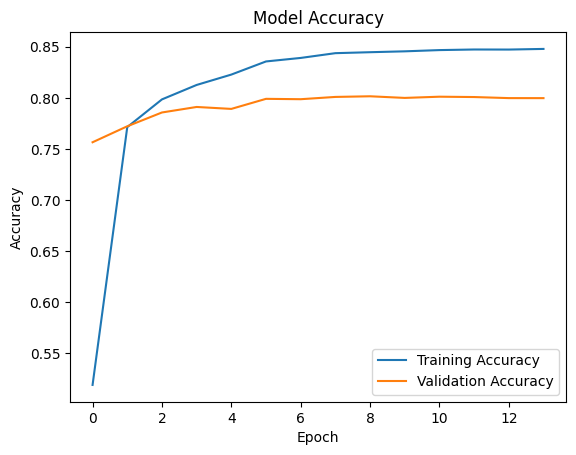

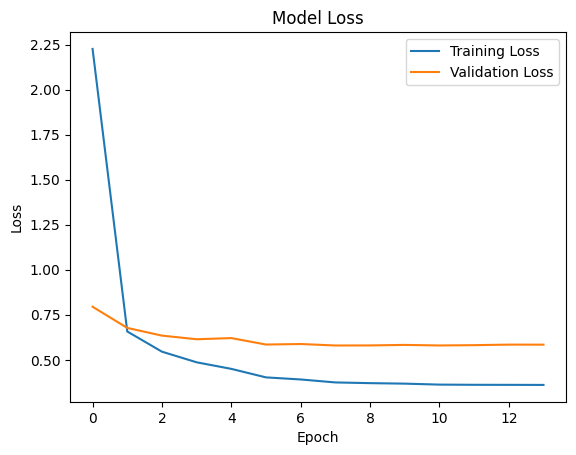

In [33]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 3. Confusion Matrix

71/71 ━━━━━━━━━━━━━━━━━━━━ 52s 715ms/step


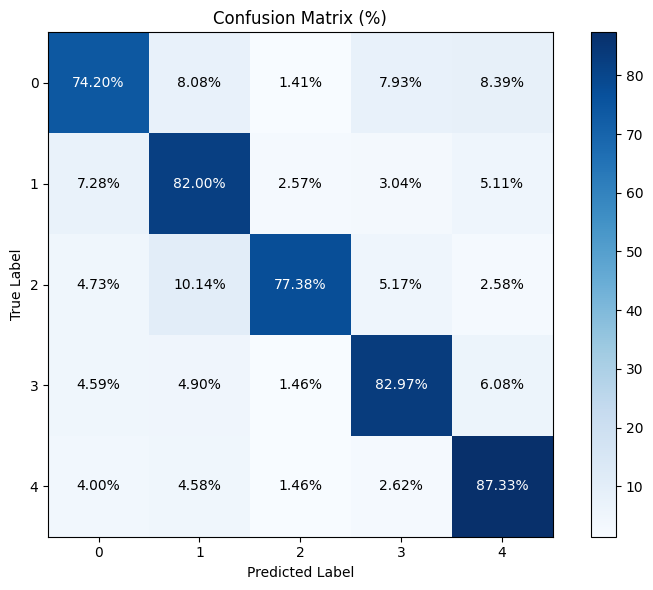

In [34]:
y_pred = np.argmax(model.predict(val_dataset), axis=1)

cm = confusion_matrix(y_val, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar(im, ax=ax)

ax.set_title("Confusion Matrix (%)")
tick_marks = np.arange(len(set(y_val)))
plt.xticks(tick_marks, [0, 1, 2, 3, 4])
plt.yticks(tick_marks, [0, 1, 2, 3, 4])

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        text = ax.text(j, i, f"{cm_normalized[i, j]:.2f}%",
                       ha="center", va="center",
                       color="white" if cm_normalized[i, j] > 50 else "black")

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

### 4. Prediction

In [35]:
def predict(text):
    cleaned_text = clean_text(text)
    tokenized_text = tokenize_text(cleaned_text)
    indexed_text = tokens_to_indices(tokenized_text)
    padded_text = padding_text(indexed_text)

    input_data = np.array([padded_text])

    prediction = model.predict(input_data)
    prediction_class = np.argmax(prediction, axis=1)

    return prediction, prediction_class

new_text = "Hari ini saya merasa kecewa dengan diri sendiri. Ada banyak hal yang saya rencanakan, namun gagal untuk tercapai. Rasanya sangat mengecewakan."
predicted = predict(new_text)
print(predicted)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
(array([[0.97086   , 0.01383822, 0.0027261 , 0.00609379, 0.00648176]],
      dtype=float32), array([0]))


0. Sad
1. Happy
2. Neutral
3. Anger
4. Scared

## Export File

### 1. Create Word to Index File

In [36]:
import pickle
with open('word_to_index.pkl', 'wb') as f:
    pickle.dump(word_to_index, f)

### 2. Download File

In [37]:
files.download('memotions.keras')
files.download('word_to_index.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>